In [ ]:
# Read in data
import pandas as pd

df = pd.read_csv(filepath_or_buffer='./communities.data', sep=',', header=None, na_values='?', keep_default_na=True)
column_names = ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']
df.columns = column_names
df

In [ ]:
# Do Lasso on all 122 variables (same as previously)
y = df['ViolentCrimesPerPop'].copy()
X = df.drop(
    columns=['state', 'county', 'community', 'communityname', 'fold', 'ViolentCrimesPerPop']
)

In [ ]:
# Lasso
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


grid = {
    'estimator__alpha': np.logspace(-3, -1, 100)
}

pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('standardise', StandardScaler()),
    ('estimator', Lasso())
])

# Setup the GridSearch
grid_search_cv = GridSearchCV(estimator=pipe, param_grid=grid, cv=3, return_train_score=True)

In [ ]:
# First just look at a single train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# and Grid Search on the training data
gs = grid_search_cv.fit(X_train, y_train)
results = gs.cv_results_

In [ ]:
# Let's look at the 'Inner' test scores for each alpha (lambda)

# Note: we introduce new terms "Inner" and "Outer". Let's look at what these are.
# We continue to split the initial sample by train (2/3) and test (1/3)
# We run gridsearch on the train only
# This involves splitting the train further into train (2/3 of 2/3 of the initial data) 
# and test (1/3 of 2/3 of the initial data). Repeat this three times.
# Inner test scores means scores that pertain to the results from the 1/3 of '2/3 of the initial data' (the inner test set)
# remember also averaged over the 3 test scores
# Outer test scores means scores that pertain to the results from the 1/3 of the initial data (the outer test set)

import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.set_xscale(value='log')
plt.errorbar(x=results['param_estimator__alpha'], y=results['mean_test_score'], yerr=results['std_test_score'])
plt.axvline(x=[gs.best_params_['estimator__alpha'],])
plt.xlabel('alpha/lambda')
plt.ylabel(r'$R^2$')
plt.title('"Inner" test scores')
plt.tight_layout()
plt.show()

In [ ]:
# By default the GridSearchCV will be 'refit' with the entire set of data passed (e.g. X_train, y_train) 
# using the best parameters found at the end of the gridsearch
# note: the "outer" test score is calculated on 1/3 of the full data
# the "outer" train score is calculated on 2/3 of the full data

r2_overall_train = gs.score(X=X_train, y=y_train)
r2_overall_test = gs.score(X=X_test, y=y_test)

plt.bar(x=['Train', 'Test'], height=[r2_overall_train, r2_overall_test])
plt.ylabel(r'$R^2$')
plt.title('"Outer" test vs train scores')
plt.show()

In [ ]:
# Let's also look at the test vs train scores
fig, ax = plt.subplots()
ax.set_xscale(value='log')
plt.errorbar(x=results['param_estimator__alpha'], y=results['mean_test_score'], yerr=results['std_test_score'], label='Test')
plt.errorbar(x=results['param_estimator__alpha'], y=results['mean_train_score'], yerr=results['std_train_score'], label='Train')
plt.axvline(x=[gs.best_params_['estimator__alpha'],],)
plt.xlabel('alpha/lambda')
plt.ylabel(r'$R^2$')
plt.title('Inner test vs train scores')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Note: we don't reproduce the above graph for "outer" test and train i.e. across the range of lambda values
# This is because we run Gridsearch only over the "inner" data i.e. 2/3 of the initial data (remember by further splitting)
# Instead, we have one statistic for the "outer" test and one for the "outer" train 
# i.e. 1/3 of initial data and 2/3 of the initial data, using the "best" hyperparameters

In [ ]:
# Now nested CV
# Note: nested CV is the same as above but we just repeat three times (rather than one initial split)


from sklearn.model_selection import cross_validate 

cv_result = cross_validate(estimator=grid_search_cv, X=X, y=y, cv=3, return_train_score=True, return_estimator=True)
test_score = cv_result['test_score']
train_score = cv_result['train_score']
plt.bar(x=range(2), 
        height = [np.mean(train_score), np.mean(test_score)], 
        tick_label=['Train', 'Test'], 
        yerr=[np.std(train_score), np.std(test_score)])
plt.ylabel(r'$R^2$')
plt.title('"Outer" cross-validation scores')
plt.show()

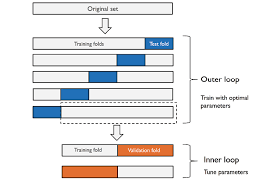

In [ ]:
# Let's look at the 'inner' test scores for each alpha (lambda)
# Note: that there are three inner test scores because remember that we repeated the gridsearch on three inner test samples

fig, ax = plt.subplots()
ax.set_xscale(value='log')

for i, estimator in enumerate(cv_result['estimator']):
    result = estimator.cv_results_
    err = plt.errorbar(x=result['param_estimator__alpha'], y=result['mean_test_score'], yerr=result['std_test_score'], label='Test')
    plt.axvline(x=[estimator.best_params_['estimator__alpha'],], color=err[0].get_color())

plt.xlabel('alpha/lambda')
plt.ylabel(r'$R^2$')
plt.title('"Inner" test scores')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Let's look at the 'inner' test scores for each alpha (lambda)
# Note: that there are also three inner train scores because remember 
# that we repeated the gridsearch on three inner train samples

fig, ax = plt.subplots()
ax.set_xscale(value='log')

for estimator in cv_result['estimator']:
    result = estimator.cv_results_
    err = plt.errorbar(x=result['param_estimator__alpha'], y=result['mean_test_score'], yerr=result['std_test_score'], label='Test')
    plt.errorbar(x=result['param_estimator__alpha'], y=result['mean_train_score'], yerr=result['std_train_score'], label='Train', 
                 linestyle='dashed', color=err[0].get_color())
    plt.axvline(x=[estimator.best_params_['estimator__alpha'],], color=err[0].get_color())
plt.xlabel('alpha/lambda')
plt.ylabel(r'$R^2$')
plt.title('"Inner" test vs train scores')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Some notes on GridSearchCV
# grid = {
#     'estimator__alpha': np.logspace(-3.5, -1, 100)
# }

# What does this actually mean?
# np.logspace(-3.5, -1, 100)

# 'Take 100 numbers between 10^-3.5 and 10^-1, in the log space
# note: that 10^-3.5 is smaller than 10^-1 (because the denominator is larger)
# and note: that the bigger the alpha the greater the penalisation, meaning we drop more X's (for LASSO)
# e.g.

for item in np.logspace(-3.5, -1, 100):
    print(item)

In [ ]:
# How do we choose?
# Start with an 'educated guess' (or default values)
# Then check to see what's actually happening in the GridSearch, and adjust if necessary
# for example, looking at a wider range to give a better picture of this, 
# we are choosing a value which maximises the score for the test data (in the GridSearch)

grid = {
    'estimator__alpha': np.logspace(-7, 0, 300)
}

pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('standardise', StandardScaler()),
    ('estimator', Lasso())
])

# Setup the GridSearch
grid_search_cv = GridSearchCV(estimator=pipe, param_grid=grid, cv=3, return_train_score=True)
gs = grid_search_cv.fit(X_train, y_train)
results = gs.cv_results_
# NOTE: There are a number of ConvergenceWarnings we weren't seeing before 
# - likely because we've expanded the alpha range we're searching over

# Convergence errors means the model did not estimate

# Let's also look at the 'inner' test vs train scores
fig, ax = plt.subplots()
ax.set_xscale(value='log')
plt.errorbar(x=results['param_estimator__alpha'], y=results['mean_test_score'], yerr=results['std_test_score'], label='Test')
plt.errorbar(x=results['param_estimator__alpha'], y=results['mean_train_score'], yerr=results['std_train_score'], label='Train')
plt.axvline(x=[gs.best_params_['estimator__alpha'],])
plt.xlabel('alpha/lambda')
plt.ylabel(r'$R^2$')
plt.title('Test vs train scores')
plt.legend()
plt.tight_layout()
plt.show()